### Forecast for lensing reconstruction nosie from LiteBIRD and delensing

In [2]:
# external
import numpy as np
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import cmb as CMB

#### Initial Setup

In [3]:
Tcmb  = 2.726e6    # CMB temperature
Lmin, Lmax  = 2, 1024       # maximum multipole of output normalization
rlmin, rlmax = 200, 1024  # CMB multipole range for reconstruction
dlmin, dlmax = 10, 1024    # lensing template
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/4.
ac2rad = np.pi/10800.
lTmax = rlmax
quad = ['TT','TE','EE','TB','EB','MV']
QDO = [True,True,True,True,True,False] # this means that TT, TE, EE, TB and EB are used for MV estimator

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [4]:
# ucl is an array of shape [0:5,0:rlmax+1] and ucl[0,:] = TT, ucl[1,:] = EE, ucl[2,:] = TE, ucl[3,:] = phiphi, ucl[4,:] = Tphi
ucl = CMB.read_camb_cls('../data/cosmo2017_10K_acc3_scalCls.dat',ftype='scal',output='array')[:,:rlmax+1]
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = CMB.read_camb_cls('../data/cosmo2017_10K_acc3_lensedCls.dat',ftype='lens',output='array')[:,:rlmax+1]

In [5]:
sig, theta = 3., 30.
nl  = np.zeros((4,rlmax+1))
nl[0,:] = .5*(sig*ac2rad/Tcmb)**2*np.exp(L*(L+1.)*(theta*ac2rad)**2/np.log(2.)/8.)
nl[1,:] = 2.*nl[0,:]
nl[2,:] = 2.*nl[0,:]
nl[0,lTmax+1:] = 1e30
ocl = lcl + nl
Nl  = np.zeros((4,rlmax+1))
sigT = np.sqrt(1./(1./30.**2+1./40**2))
sigP = np.sqrt(1./(1./60.**2+1./95**2))
Nl[0,:] = (sigT*ac2rad/Tcmb)**2*np.exp(L*(L+1.)*(7.*ac2rad)**2/np.log(2.)/8.)
Nl[1,:] = (sigP*ac2rad/Tcmb)**2*np.exp(L*(L+1.)*(7.*ac2rad)**2/np.log(2.)/8.)
Nl[2,:] = Nl[1,:]
Nl[0,lTmax+1:] = 1e30
print(sigT,sigP)
nlcomb = 1./(1./nl+1./Nl)

24.0 50.72933418185826


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


#### Lensing Reconstruction Noise Level

In [6]:
# LiteBIRD
Ag, Ac, Wg, Wc = cs.norm_quad.qall('lens',QDO,Lmax,rlmin,rlmax,lcl,ocl,lfac='k')

In [7]:
# Planck
Agpl, Acpl, __, __ = cs.norm_quad.qall('lens',QDO,Lmax,rlmin,rlmax,lcl,lcl+Nl,lfac='k')

In [8]:
# Planck+LiteBIRD
AgC, AcC, __, __ = cs.norm_quad.qall('lens',QDO,Lmax,rlmin,rlmax,lcl,lcl+nlcomb,lfac='k')

In [9]:
ll, AgP = np.loadtxt('../data/planck_PR3_nlkk.dat',unpack=True,usecols=(0,1))
AgSO = np.concatenate((np.array([0,0]),np.loadtxt('../data/so.dat',unpack=True)[7]))[:Lmax+1]
AcSO = np.concatenate((np.array([0,0]),np.loadtxt('../data/so.dat',unpack=True)[14]))[:Lmax+1]

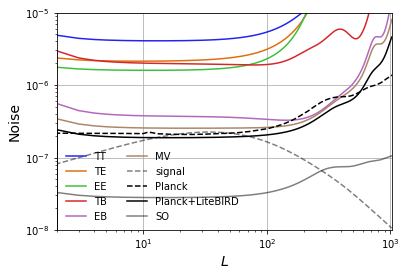

In [10]:
pl.plot_1dstyle(xmin=2,xmax=Lmax,ymin=1e-8,ymax=1e-5,xlab=r'$L$',ylab='Noise',xlog=True,ylog=True,grid=True)
for qi, q in enumerate(quad):
    plot(L,Ag[qi,:],ls='-',label=q)
plot(L,Lfac*ucl[3],color='k',ls='--',alpha=.5,label='signal')
plot(ll,AgP,color='k',ls='--',label='Planck')
plot(L,AgC[5,:],color='k',label='Planck+LiteBIRD')
plot(L,AgSO,color='k',alpha=.5,label='SO')
legend(ncol=2)

SNR

In [10]:
# LiteBIRD
print( np.sqrt(0.7*np.sum((L[Lmin:Lmax+1]+.5)*ucl[3,Lmin:Lmax+1]**2/(ucl[3,Lmin:Lmax+1]+Ag[5,Lmin:Lmax+1]/Lfac[Lmin:Lmax+1])**2)) )
# Planck
print( np.sqrt(0.7*np.sum((L[Lmin:Lmax+1]+.5)*ucl[3,Lmin:Lmax+1]**2/(ucl[3,Lmin:Lmax+1]+AgP[Lmin:Lmax+1]/Lfac[Lmin:Lmax+1])**2)) )
# Combine
print( np.sqrt(0.7*np.sum((L[Lmin:Lmax+1]+.5)*ucl[3,Lmin:Lmax+1]**2/(ucl[3,Lmin:Lmax+1]+AgC[5,Lmin:Lmax+1]/Lfac[Lmin:Lmax+1])**2)) )
# SO
print( np.sqrt(0.4*np.sum((L[Lmin:Lmax+1]+.5)*ucl[3,Lmin:Lmax+1]**2/(ucl[3,Lmin:Lmax+1]+AgSO[Lmin:Lmax+1]/Lfac[Lmin:Lmax+1])**2)) )

48.422544515109394
46.57656409980429
55.68759669678431
128.40638973599562


Check iterative estimator

In [11]:
AgIt, __ = cs.norm_quad.qeb_iter(Lmax,rlmax,rlmin,rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:],ucl[3,:],iter=50)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


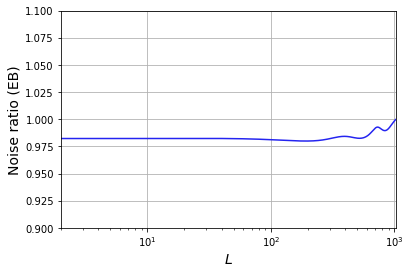

In [12]:
pl.plot_1dstyle(xmin=2,xmax=Lmax,ymin=.9,ymax=1.1,xlab=r'$L$',ylab='Noise ratio (EB)',xlog=True,grid=True)
plot(L,Lfac*AgIt/Ag[4,:])

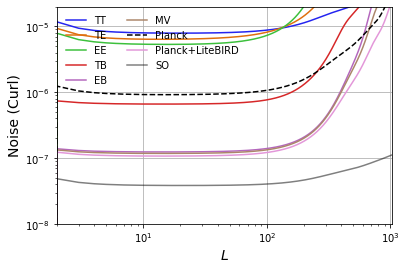

In [13]:
pl.plot_1dstyle(xmin=2,xmax=Lmax,ymin=1e-8,ymax=2e-5,xlab=r'$L$',ylab='Noise (Curl)',xlog=True,ylog=True,grid=True)
for qi, q in enumerate(quad):
    plot(L,Ac[qi,:],ls='-',label=q)
plot(L,Acpl[5,:],ls='--',color='k',label='Planck')
plot(L,AcC[5,:],ls='-',label='Planck+LiteBIRD')
plot(L,AcSO,ls='-',color='k',alpha=0.5,label='SO')
#plot(L,Lfac*ucl[3],color='k',ls='--',label='signal')
#plot(ll,AgP,color='k',label='Planck')
legend(ncol=2)

#### Delensing

In [14]:
bb = basic.delens.lensingbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid v

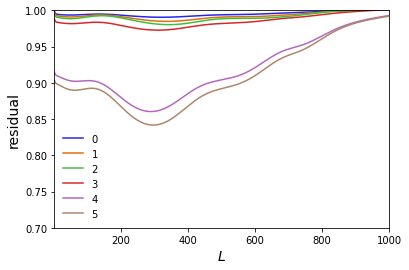

In [15]:
pl.plot_1dstyle(ymin=.7,ymax=1.,xmin=2,xmax=1000,ylab='residual')
for i in range(6):
    WE = ucl[1,:dlmax+1]/(ucl[1,:dlmax+1]+nl[1,:dlmax+1])
    Wp = ucl[3,:]/(ucl[3,:]+Ag[i]/Lfac)
    rbb_lb = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE, Wp[:dlmax+1])
    plot(L[:dlmax+1],rbb_lb/bb,label=str(i))
legend()

In [16]:
WE = ucl[1,:dlmax+1]/(ucl[1,:dlmax+1]+Nl[1,:dlmax+1])
Wp = ucl[3,:]/(ucl[3,:]+AgP[:rlmax+1]/Lfac)
rbb_pl = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE, Wp[:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [17]:
WEcomb = ucl[1,:dlmax+1]/(ucl[1,:dlmax+1]+nlcomb[1,:dlmax+1])
Wpcomb = ucl[3,:]/(ucl[3,:]+AgC[5,:rlmax+1]/Lfac)
rbb_co = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WEcomb, Wpcomb[:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


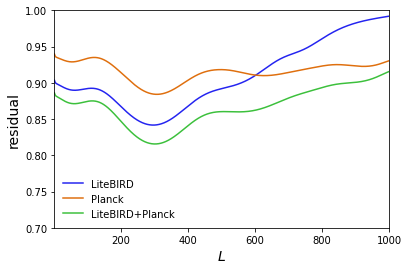

In [18]:
pl.plot_1dstyle(ymin=.7,ymax=1.,xmin=2,xmax=1000,ylab='residual')
plot(L[:dlmax+1],rbb_lb/bb,label='LiteBIRD')
plot(L[:dlmax+1],rbb_pl/bb,label='Planck')
plot(L[:dlmax+1],rbb_co/bb,label='LiteBIRD+Planck')
legend()

#### ISW x phi

In [19]:
# LiteBIRD
np.sqrt(0.7*np.sum((2*L[Lmin:Lmax+1]+1.)*ucl[4,Lmin:Lmax+1]**2/((ucl[3,Lmin:Lmax+1]+Ag[5,Lmin:Lmax+1]/Lfac[Lmin:Lmax+1])*ocl[0,Lmin:Lmax+1])))

3.9577224624434755

In [20]:
# Planck
LminP = 8
np.sqrt(0.7*np.sum((2*L[LminP:Lmax+1]+1.)*ucl[4,LminP:Lmax+1]**2/((ucl[3,LminP:Lmax+1]+AgP[LminP:Lmax+1]/Lfac[LminP:Lmax+1])*ocl[0,LminP:Lmax+1])))

3.906058374779423

In [21]:
# LiteBIRD+Planck
np.sqrt(0.7*np.sum((2*L[Lmin:LminP]+1.)*ucl[4,Lmin:LminP]**2/((ucl[3,Lmin:LminP]+Ag[5,Lmin:LminP]/Lfac[Lmin:LminP])*ocl[0,Lmin:LminP])) \
       +0.7*np.sum((2*L[LminP:Lmax+1]+1.)*ucl[4,LminP:Lmax+1]**2/((ucl[3,LminP:Lmax+1]+AgC[5,LminP:Lmax+1]/Lfac[LminP:Lmax+1])*ocl[0,LminP:Lmax+1])))

4.236362421748693